<a href="https://colab.research.google.com/github/DmitryKutsev/DeepHW/blob/master/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install youtokentome

     |████████████████████████████████| 1.7MB 5.1MB/s 


In [ ]:
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
# !apt-get update
# !apt-get install cuda

In [ ]:
# !pip install mxnet-cu92

In [5]:
import math
import numpy as np
import pandas as pd

import random
import json
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from matplotlib import pyplot as plt

import youtokentome as yttm

In [6]:
print(torch.cuda.device_count())

1


In [7]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [8]:
device = torch.device('cuda:0')

In [9]:
# !pip install --upgrade --force-reinstall -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# !unzip '/content/drive/My Drive/unsupervised.csv.zip'

Archive:  /content/drive/My Drive/unsupervised.csv.zip
  inflating: unsupervised.csv        


In [19]:
!unzip '/content/drive/My Drive/qa_data.jsonl.zip'

Archive:  /content/drive/My Drive/qa_data.jsonl.zip
  inflating: qa_data.jsonl           
  inflating: __MACOSX/._qa_data.jsonl  


In [21]:
# questions = pd.read_csv('unsupervised.csv')
# questions.question = questions.question.map(lambda x: x.lower())

qa_data = list()

with open('qa_data.jsonl') as file_object:
    for line in file_object:
        qa_data.append(json.loads(line.strip()))
file_object.close()
qa_data = qa_data[:math.ceil(len(qa_data)*0.4)]#!!!!

In [38]:
with open('for_bpe.txt', 'w', encoding='utf-8') as f:
    for que in train_df['question']:
        f.write(que + '\n')
f.close()

vocab_size = 30_000
model_path = 'pretrained_bpe_lm.model'

In [39]:
%%time
# обучаем
# раскомментируйте этот код, чтобы обучить bpe
yttm.BPE.train(data='for_bpe.txt', vocab_size=vocab_size, model=model_path)

CPU times: user 7.93 s, sys: 651 ms, total: 8.58 s
Wall time: 5.32 s


In [40]:
# загружаем токенизатор
tokenizer = yttm.BPE(model=model_path)

In [57]:
for i in qa_data:
  i['tok_quest'] = tokenizer.encode(i['question'], bos=True, eos=True)
  if i['responses']:
    i['tok_answ'] = tokenizer.encode(i['responses'][0], bos=True, eos=True)
  else:
    i['tok_answ'] = tokenizer.encode(i['responses'], bos=True, eos=True)

In [58]:
qa_data[0]


{'category': 'Бизнес, Финансы',
 'question': 'долго ли идут деньги с яндексденег на карту visa?',
 'responses': ['нет. прорыв 35 ;)'],
 'tok_answ': [2, 3329, 372, 423, 14, 5397, 7674, 3],
 'tok_quest': [2,
  1668,
  369,
  5503,
  999,
  305,
  8404,
  22140,
  26,
  322,
  2848,
  7130,
  5726,
  3]}

In [59]:
train_border = math.ceil(len(qa_data)*0.6)
test_border = math.ceil(len(qa_data)*0.8)

In [60]:
train_df = pd.DataFrame(qa_data[:train_border])
test_df = pd.DataFrame(qa_data[train_border:test_border])
validation_df = pd.DataFrame(qa_data[test_border: ])

In [61]:
train_df


,question,category,responses,tok_quest,tok_answ
0,долго ли идут деньги с яндексденег на карту visa?,"Бизнес, Финансы",[нет. прорыв 35 ;)],"[2, 1668, 369, 5503, 999, 305, 8404, 22140, 26...","[2, 3329, 372, 423, 14, 5397, 7674, 3]"
1,можно ли зарегистрировать авто в другом регионе,"Авто, Мото",[можно на родственника из того региона.. . а ...,"[2, 404, 369, 17788, 643, 303, 4357, 18899, 3]","[2, 404, 322, 4906, 983, 431, 1472, 13613, 363..."
2,что делать если у меня очень тонкие ногти а хо...,Красота и Здоровье,"[витамины и умная эмаль (каждый день), ванночк...","[2, 341, 564, 442, 338, 566, 665, 15576, 4690,...","[2, 7103, 316, 18444, 15871, 329, 10558, 22877..."
3,в чем отличие медитации от йоги?,Спорт,"[букв в йоге меньше, в медитации ты просто сид...","[2, 303, 521, 6997, 3435, 8107, 368, 3017, 416...","[2, 6959, 303, 3017, 1074, 2979, 3]"
4,когда начнут линейку фильмов про лигу чемпионов?,Спорт,[а не фильм? жалко... а я то думал - хорошая к...,"[2, 550, 13024, 15255, 382, 3992, 372, 11142, ...","[2, 344, 346, 2387, 5140, 414, 344, 418, 405, ..."
...,...,...,...,...,...
674110,могут ли в 15 лет взять работать санитаркой в ...,Красота и Здоровье,"[могут на неполный рабочий день., да . с работ...","[2, 1351, 369, 303, 1325, 603, 1208, 1462, 240...","[2, 1351, 322, 14490, 478, 7538, 6768, 3]"
674111,можно сократить беременость симки?,"Семья, Дом, Дети","[никак. там она и так короткая. 3дня, ахахахах...","[2, 404, 6445, 1537, 16239, 940, 1924, 776, 3]","[2, 2895, 29, 898, 781, 316, 428, 17694, 29, 6..."
674112,в каком случае нужно обязательно менять работу?,"Работа, Карьера","[когда деваться некуда..., кода босс сильно да...","[2, 303, 1007, 4648, 662, 2258, 4120, 3330, 3]","[2, 550, 380, 1173, 18529, 414, 3]"
674113,вы часто сами себя накручиваете на ровном мест...,"Знакомства, Любовь, Отношения","[если меня нет рядом, значит мыссленно и душой...","[2, 355, 1116, 2259, 849, 17443, 385, 2061, 32...","[2, 442, 566, 661, 22795, 1549, 747, 1821, 128..."


In [29]:
tokenizer.encode('аа памагити пожалст', bos=True, eos=True, output_type=yttm.OutputType.SUBWORD)

['<BOS>', '▁аа', '▁па', 'ма', 'ги', 'ти', '▁пожал', 'ст', '<EOS>']

In [82]:

batch_size = 64

max_len = 32 # это типа с запасом?

pad_index = 0
eos_index = 3

In [78]:
class LanguageModelData(torch.utils.data.Dataset):
    
    def __init__(self, data, max_len, pad_index, eos_index):
        
        self.data = data
        
        self.max_len = max_len
        
        self.pad_index = pad_index
        self.eos_index = eos_index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        x = self.data['tok_quest'][index][:self.max_len]
        y = self.data['tok_answ'][index][:self.max_len]        
        
        pads_x = [self.pad_index] * (self.max_len - len(x))
        pads_y = [self.pad_index] * (self.max_len - len(y))

        x = torch.tensor(x + pads_x).long()
        y = torch.tensor(y + pads_y).long()
        
        return x, y

In [89]:
train_df['tok_answ'][0]

[2, 3329, 372, 423, 14, 5397, 7674, 3]

In [79]:
train_df['tok_quest'][0]

[2, 1668, 369, 5503, 999, 305, 8404, 22140, 26, 322, 2848, 7130, 5726, 3]

In [113]:
for x, y in train_loader:
  break

In [123]:
# sent = tokenizer.encode('аа памагити пожалст', bos=True, eos=True)
# x = sent[:max_len]

# pads_x = [pad_index] * (max_len - len(x))
# x = torch.tensor([x + pads_x]).long()
# x = x.to(device)
# x
# with torch.no_grad():
#   pred = model(x)
# pred

tensor([[[-4.9844, -2.5082, 16.4716,  ..., -3.1319, -3.5222, -2.2952],
         [-5.6445, -2.7812,  2.1362,  ..., -4.9820, -4.2445, -4.1562],
         [-7.5835, -0.6567, -0.1132,  ..., -5.3173, -4.5503, -3.8620],
         ...,
         [-6.6054, -0.6446, -1.2988,  ..., -3.6615, -3.3132, -2.0028],
         [-6.5685, -0.6181, -1.2996,  ..., -3.6491, -3.3183, -1.9881],
         [-6.5349, -0.5935, -1.3000,  ..., -3.6372, -3.3230, -1.9744]]],
       device='cuda:0')

In [80]:

# надо выбрать максимальную длину
lengths = np.array([len(x) for x in train_df['tok_quest']])
np.percentile(lengths, q=95)

28.0

In [83]:
train_dataset = LanguageModelData(data=train_df, max_len=max_len, 
                                  pad_index=pad_index, eos_index=eos_index)
validation_dataset = LanguageModelData(data=validation_df, max_len=max_len,
                                       pad_index=pad_index, eos_index=eos_index)

len(train_dataset), len(validation_dataset)

(674115, 224705)

In [84]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)

In [85]:
for x, y in train_loader:
    break

In [91]:
# пробежимся по итератору, чтобы убедиться что ничего не падает и он работает достаточно быстро

progress_bar = tqdm(total=len(validation_loader.dataset), desc='Testing')

for x, y in validation_loader:
    progress_bar.update(x.size(0))
    
progress_bar.close()

Testing: 100%|██████████| 224705/224705 [00:06<00:00, 35009.07it/s]


In [92]:
class LanguageModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_dim, num_layers, dropout, padding_idx):
        
        super().__init__()
        
        # просто эмбеддинги
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, 
                                                  embedding_dim=embedding_dim,
                                                  padding_idx=padding_idx)
        
        # просто lstm
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, 
                                  hidden_size=model_dim,
                                  num_layers=num_layers, 
                                  dropout=0.3,
                                  batch_first=True)
        
        # выходная матрица эмбеддингов
        # количество выходных фичей равно размеру словаря
        # то есть это задача мультиклассовой классификации, но только классов очень много
        self.language_model_head = torch.nn.Linear(in_features=model_dim,
                                                   out_features=vocab_size,
                                                   bias=False)
        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        
        x, _ = self.lstm(x)
        
        # к каждому элементу последовательности применяется выходная матрица эмбеддингов, 
        # которая переводит вектор lstm в предсказание конкретного слова
        x = self.language_model_head(x)
        
        return x

In [93]:
embedding_dim = 128
model_dim = 128
num_layers = 2
dropout = 0.35

In [94]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim,
                      model_dim=model_dim, num_layers=num_layers,
                      dropout=dropout, padding_idx=pad_index)
model.to(device)

LanguageModel(
  (embedding_layer): Embedding(30000, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3)
  (language_model_head): Linear(in_features=128, out_features=30000, bias=False)
)

In [95]:

# у нас есть тег eos (end of sentence), который есть в каждом тренировочном примере
# мы не будем считать лосс для падов
# вместо этого будем останавливать генерирование моделью в момент, когда она сгенерирует тег eos
# 
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)
optimizer = torch.optim.Adam(params=model.parameters())

In [97]:

# функция для обучения одной эпохи
# почти все как всегда

def train(model, loader, criterion, optimizer, last_n_losses=500, verbose=True):
    
    losses = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Train')

    model.train()

    for x, y in loader:

        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [98]:
epoch_losses = train(model, validation_loader, criterion, optimizer)

Train: 100%|██████████| 3512/3512 [01:50<00:00, 31.82it/s, loss=7.28, perplexity=1.45e+3]


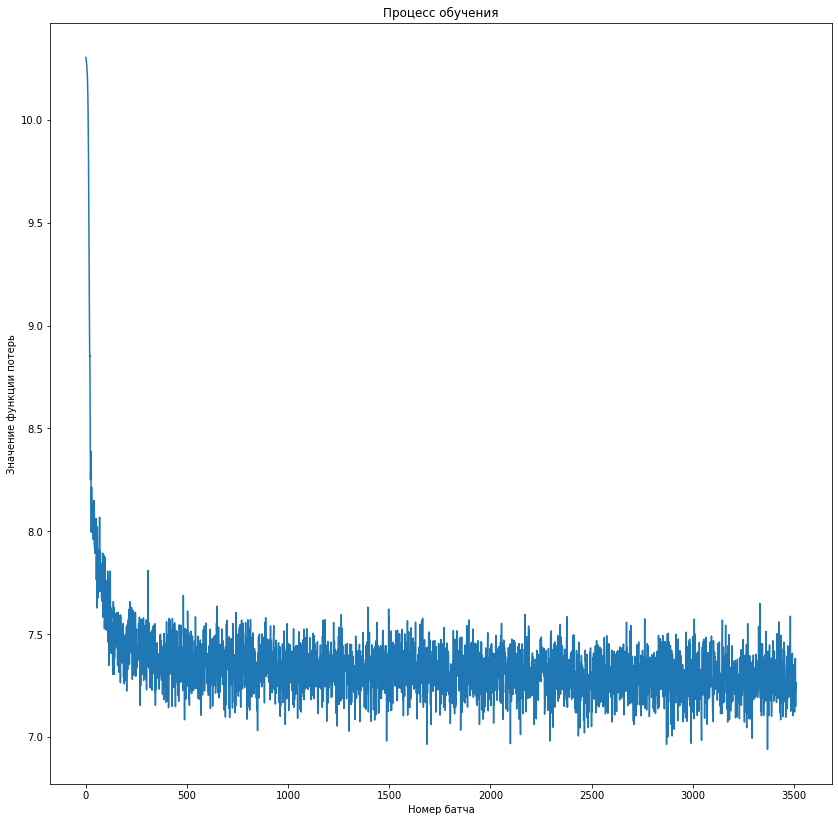

In [99]:

plt.figure(figsize=(14, 14))
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(epoch_losses)

In [100]:
def evaluate(model, loader, criterion, last_n_losses=500, verbose=True):
    
    losses = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Evaluate')

    model.eval()

    for x, y in loader:

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            pred = model(x)

        loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [101]:

val_losses = evaluate(model, validation_loader, criterion)
f'Val loss - {np.mean(val_losses):.3f} perplexity - {np.exp(np.mean(val_losses)):.3f}'

Evaluate: 100%|██████████| 3512/3512 [00:50<00:00, 69.56it/s, loss=7.2, perplexity=1.33e+3]


'Val loss - 7.242 perplexity - 1396.553'

In [103]:
class SpatialDropout(torch.nn.Dropout2d):
    
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T)
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

In [124]:
spatial_dropout = SpatialDropout()
common_dropout = torch.nn.Dropout()

In [125]:
class LanguageModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_dim, num_layers,
                 padding_idx, dropout=0.35, weight_tying=True):
        
        super().__init__()
        
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,
                                                  embedding_dim=embedding_dim, padding_idx=padding_idx)
        
        self.embedding_dropout = SpatialDropout(p=dropout)
        
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=model_dim, 
                                  num_layers=num_layers, dropout=dropout, batch_first=True)
        
        self.language_model_head = torch.nn.Linear(in_features=model_dim, out_features=vocab_size, bias=False)
        
        # как раз здесь задаем, чтобы веса входящего и выходящего слоя эмбеддингов шарились
        if weight_tying and embedding_dim == model_dim:
            self.language_model_head.weight = self.embedding_layer.weight
        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        
        x = self.embedding_dropout(x)
        
        x, _ = self.lstm(x)
        
        x = self.language_model_head(x)
        
        return x

In [126]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, model_dim=model_dim, 
                      num_layers=num_layers, dropout=dropout, padding_idx=pad_index, weight_tying=True)

In [127]:
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())

In [128]:
epoch_losses = train(model, validation_loader, criterion, optimizer)

Train: 100%|██████████| 3512/3512 [01:46<00:00, 32.83it/s, loss=7.33, perplexity=1.52e+3]


In [129]:

model.eval()

with torch.no_grad():
    
    pred = []
    
    zeros = torch.zeros(num_layers, x.size(0), model_dim, dtype=torch.float32, device=x.device)
    hx = (zeros, zeros)
    
    # семплируем начальный токен bos для каждого предложения
    current_token = x[:, 0].unsqueeze(1)
    
    for timestamp in range(x.size(1)):
        
        # пока все то же самое
        emb = model.embedding_layer(current_token)

        emb = model.embedding_dropout(emb)

        lstm_out, hx = model.lstm(emb, hx)

        next_token_prediction = model.language_model_head(lstm_out)
        
        pred.append(next_token_prediction)
        
        # но вот здесь мы семплируем предсказания сети и передадим это как текущий токен для следующего таймстемпа
        current_token = next_token_prediction.argmax(dim=2)
        
    pred = torch.cat(pred, dim=1)
    
model.train()
    
tokens = pred.argmax(dim=-1).detach().cpu().numpy()

In [130]:
tokens

array([[  2, 344, 346, 346, 346,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3]])

In [131]:
predicted_texts = tokenizer.decode(tokens.tolist())

In [135]:

for n in range(1):
    print(predicted_texts[n][:predicted_texts[n].index('<EOS>')])

<BOS> а не не не


In [137]:
'SequenceBucketingData'

'SequenceBucketingData'